In [296]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time
import pickle
import math
from datetime import date
from scipy.signal import wiener
import pandas as pd 
from scipy import integrate
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
import xarray as xr

In [324]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c

  return d

def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x):
    floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            floe_idx += 1
            
    # Removing spurious floes (< 10m, > 10 km, fb<0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    #
    return floe_chord_lengths, floe_fb

def get_year_composite(xfld,fld):
    # Assumes xfld is in days
    dt = (xfld[1] - xfld[0])/360
    npoints_yr = int(np.floor(1/dt))
    nyears = int(np.floor(len(fld)/npoints_yr))
    fld_out = np.zeros(npoints_yr)
    fld_out_raw = np.zeros([npoints_yr,nyears])
    st = 0
    en = npoints_yr
    xx = np.linspace(0,360*dt*(npoints_yr-1),num=npoints_yr)
    for iyear in range(nyears):
        fld_tmp = fld[st:en]  
        fld_tmp -= np.mean(fld_tmp) 
        m,b = np.polyfit(xx,fld_tmp, 1)
        fld_tmp = fld_tmp - (m*xx + b)
        fld_out += fld_tmp
        fld_out_raw[:,iyear] = fld_tmp*1
        st = en 
        en = st + npoints_yr 
    fld_out = fld_out/nyears
    fld_std = np.nanstd(fld_out_raw,axis=1)
    print(np.shape(fld_std))
    return xx, fld_out, fld_std

def get_year_composite_new(xfld,fld,ndays_year):
    # Assumes xfld is in days and that each element represents the start of the period
    dt = (xfld[1] - xfld[0])/ndays_year # timestep in years
    npoints_yr = int(np.floor(1/dt))
    nyears = int(np.floor(len(fld)/npoints_yr))
    fld_out = np.zeros(npoints_yr)
    st = 0
    en = npoints_yr
    xx = np.linspace(0,ndays_year*dt*(npoints_yr-1),num=npoints_yr)
    for iyear in range(nyears):
        fld_tmp = fld[st:en]  
        fld_tmp -= np.mean(fld_tmp) 
        m,b = np.polyfit(xx,fld_tmp, 1)
        fld_tmp = fld_tmp - (m*xx + b)
        fld_out += fld_tmp
        st = en 
        en = st + npoints_yr 
    fld_out = fld_out/nyears
    return xx, fld_out

# Compositing function without detrending
def get_year_composite_no_detrending(xfld,fld,ndays_year):
    # Assumes xfld is in days and that each element represents the start of the period
    dt = (xfld[1] - xfld[0])/ndays_year # timestep in years
    npoints_yr = int(np.floor(1/dt))
    nyears = int(np.floor(len(fld)/npoints_yr))
    fld_out = np.zeros(npoints_yr)
    fld_out_raw = np.zeros([npoints_yr,nyears])
    st = 0
    en = npoints_yr
    xx = np.linspace(0,ndays_year*dt*(npoints_yr-1),num=npoints_yr)
    for iyear in range(nyears):
        fld_tmp = fld[st:en]  
#         fld_tmp -= np.mean(fld_tmp) 
#         m,b = np.polyfit(xx,fld_tmp, 1)
#         fld_tmp = fld_tmp - (m*xx + b)
        fld_out_raw[:,iyear] = fld_tmp*1
        fld_out += fld_tmp
        st = en 
        en = st + npoints_yr 
    fld_std = np.nanstd(fld_out_raw,axis=1)
    fld_out = fld_out/nyears
    return xx, fld_out, fld_std

def get_periodic_smoothing(fld,filter_window,):
    # Smoothes 1D data assuming it is periodic
    npoints = len(fld)
    fld_per = np.concatenate((fld,fld,fld))
    #fld_per = wiener(fld_per, mysize=filter_window)
    fld_per = gaussian_filter1d(fld_per, filter_window)
    return fld_per[npoints:(2*npoints)]

def get_vsquareness(yy_norm):
    return integrate.simpson(yy_norm) / len(yy_norm)

<ipython-input-406-21da4df06f05>:49: RuntimeWarning: divide by zero encountered in log10
  alpha,_ = np.polyfit(xx, np.log10(yy), 1)
<ipython-input-406-21da4df06f05>:146: RuntimeWarning: Mean of empty slice
  yy2[ii] = np.nanmean(yy_removeyearly_interp[ii-rmean_days:ii+rmean_days+1])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


b
[-0.11964842 -0.04669571 -0.02851497  0.02671801  0.0484837   0.09701451
  0.10001978  0.1173886   0.04791557  0.04924619  0.02014398  0.00477619
 -0.00627934  0.02926086  0.05760086  0.13338811  0.1368358   0.1248744
  0.12171828  0.13247123  0.09743598  0.08005523  0.06852444  0.03924498
 -0.00520557 -0.01265644 -0.06144806 -0.10461088 -0.12778095 -0.18323704
 -0.13862658 -0.07044991 -0.04094609 -0.0330639  -0.00063044 -0.01145297
  0.04112844  0.01507388  0.04160755  0.03890934  0.10854555  0.16458739
  0.20068938  0.17911623  0.21206121  0.15454606  0.16305546  0.13701564
  0.07846779  0.06790515  0.05971237 -0.00704735 -0.04120296 -0.07518666
 -0.14873349 -0.16779449 -0.26414393 -0.31755225 -0.3280562  -0.32245261
 -0.32791682 -0.31806366 -0.32116678 -0.28073212 -0.2180972  -0.17540906
 -0.09368886 -0.06991    -0.01919301  0.04069224  0.09010797  0.18921747
  0.24097296  0.24923369  0.2616451   0.28501861  0.22698473  0.21141926
  0.0909687   0.00787268 -0.05010608 -0.05543062 -

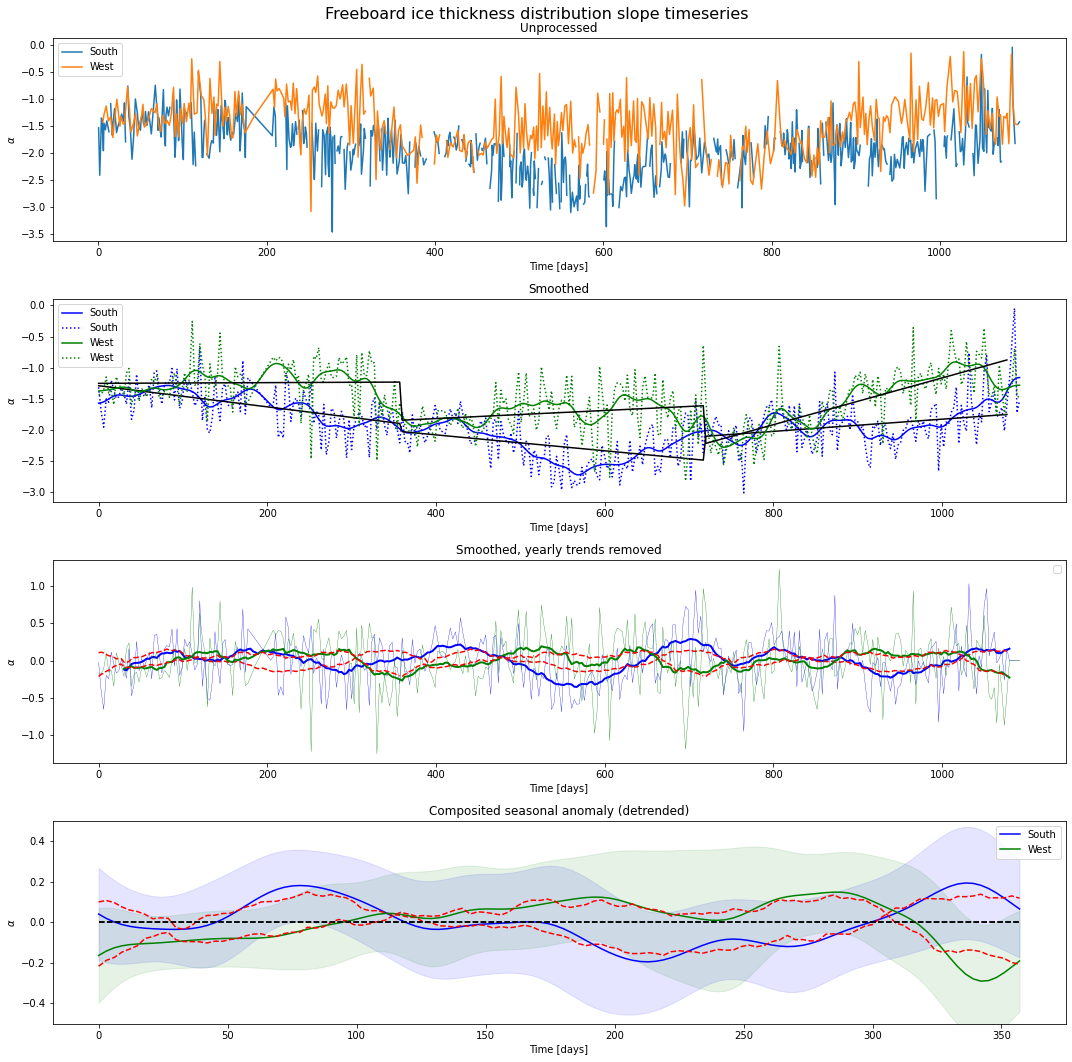

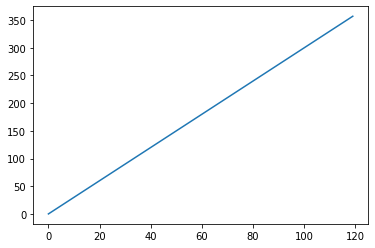

In [406]:
import scipy

# Freeboard ITD timeseries
add_individual_years = 1

path = 'data/Array/'
regions_all = ['South','West']
years_all = [2019,2020,2021]
nyears = len(years_all)
nregions = len(regions_all)
nbins = 49 # Hard coded from the data (len(floe_chord_bin_means))
# ngroups = np.shape(mth_groups)[0]
ITD_slopes = [[],[]]
day_numbers = [[],[]]
ref_date = date(2019, 1, 1)
reg_cols = ['b','g','r']
#
# Looping through regions
for iregion in range(nregions):
    # Looping through years
    for iyear in range(nyears): 
        # Loading data
        file_name = path + 'fb_distribution_' + regions_all[iregion] + '_' + str(years_all[iyear]) + '.pkl'
        open_file = open(file_name, "rb")
        [mth_all, day_all, ITD_bins, ITD_all] = pickle.load(open_file)
        open_file.close()
        #
        # Creating chunk
        chunk_fb = np.zeros(nbins)
        chunk_day = 0
        chunk_cnt = 0
        chunk_thresh = 3
        # Looping through all days and calculating slopes for chunks of ~ 10 days
        for iday in range(len(day_all)): 
            # Checking if data is available
            if (~np.isnan(mth_all[iday])):
                chunk_fb += ITD_all[:,iday]
                my_date = date(years_all[iyear], int(mth_all[iday]), int(day_all[iday])) - ref_date
                chunk_day += my_date.days
                chunk_cnt += 1
                #
                if chunk_cnt == chunk_thresh:
                    # Getting date
                    my_date = date(years_all[iyear], int(mth_all[iday]), int(day_all[iday])) - ref_date
                    day_numbers[iregion].append(chunk_day/chunk_thresh)
                    # Getting slope
                    xx = ITD_bins
                    yy = chunk_fb/chunk_thresh
                    alpha,_ = np.polyfit(xx, np.log10(yy), 1)
                    ITD_slopes[iregion].append(alpha)
                    #
                    chunk_fb = np.zeros(nbins)
                    chunk_day = 0
                    chunk_cnt = 0
                    
# Plotting and saving data
labels_all = ['South','West','Combined']
nn = int(np.floor(360/chunk_thresh))
nlabels = len(labels_all)   
#
ninterp = int(floor(nyears*364/chunk_thresh))
#
ITD_slope_x = np.zeros((ninterp+1,nlabels))   
ITD_slope_y = np.zeros((ninterp+1,nlabels))  
ITD_slope_seas_x = np.zeros((nn,nlabels))   
ITD_slope_seas_y = np.zeros((nn,nlabels))  
ITD_slope_seas_y_stdlo = np.zeros((nn,nlabels))  
ITD_slope_seas_y_stdhi = np.zeros((nn,nlabels))  
#            
fig = plt.figure(figsize = (15,15))
fig.suptitle("Freeboard ice thickness distribution slope timeseries", fontsize=16)
ax = fig.add_subplot(1,4,1)
ax = fig.add_subplot(1,4,2)
ax = fig.add_subplot(1,4,3)
ax = fig.add_subplot(1,4,4)
for iregion in range(nregions):
    # Getting data
    if iregion < nregions:
        xx = day_numbers[iregion]
        yy = np.array(ITD_slopes[iregion])
    else:
        daynums_fullint = np.linspace(0,chunk_thresh*ninterp,num=ninterp+1)
        interpolant1 = interpolate.interp1d(day_numbers[0], np.array(ITD_slopes)[0],fill_value="extrapolate")
        interpolant2 = interpolate.interp1d(day_numbers[1], np.array(ITD_slopes)[1],fill_value="extrapolate")
        yy1_interp = interpolant1(daynums_fullint)
        yy2_interp = interpolant2(daynums_fullint)
        xx = daynums_fullint*1
        yy = (yy1_interp+yy2_interp)/2
    #    
    # No processing
    plt.subplot(4,1,1)
    plt.plot(xx,yy,label=labels_all[iregion])#,color=reg_cols[iregion])
    print(reg_cols[iregion])
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Unprocessed')
    plt.legend()
    #
    # Interpolated
    plt.subplot(4,1,2)
    xx_interp = np.linspace(0,chunk_thresh*ninterp,num=ninterp+1)
    yy = pd.Series(yy).interpolate().fillna(method='bfill').to_numpy()
    interpolant = interpolate.interp1d(xx, yy,fill_value="extrapolate")
    yy_interp = interpolant(xx_interp)
    yfunc = []
    for yr in range(0,3):
        slope,intercept,c,d,e = scipy.stats.linregress(xx_interp[yr*120:(yr+1)*120],yy_interp[yr*120:(yr+1)*120])
        yfunc = np.append(yfunc,slope*np.squeeze(xx_interp[yr*120:(yr+1)*120])+intercept)
    yy_smooth = gaussian_filter1d(yy_interp,3)
    plt.plot(xx_interp,yy_smooth,label=labels_all[iregion],c=reg_cols[iregion])
    plt.plot(xx_interp,yy_interp,label=labels_all[iregion],linestyle=':',c=reg_cols[iregion])
    plt.plot(xx_interp[0:len(yfunc)],yfunc,'k-')
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Smoothed')
    plt.legend()
    #
    # Interpolated but for each season
    plt.subplot(4,1,3)
    if add_individual_years:
        yy_next = np.zeros(np.shape(yy_smooth[yn:yn+120]))
        yy_min = np.nan*np.ones(np.shape(yy_smooth[yn:yn+120]))
        yy_max = np.nan*np.ones(np.shape(yy_smooth[yn:yn+120]))
        #yy_removeyearly_smooth = np.zeros(np.shape(yy_smooth))
        yy_removeyearly_interp = np.zeros(np.shape(yy_interp))
        for yn in np.arange(0,360,120):
            #yy_removeyearly_smooth[yn:yn+120] = yy_smooth[yn:yn+120] - yfunc[yn:yn+120]
            yy_removeyearly_interp[yn:yn+120] = yy_interp[yn:yn+120] - yfunc[yn:yn+120]
            #if iregion < 2:
            #    plt.plot(xx_interp[0:120],np.squeeze(yy_smooth[yn:yn+120])-np.nanmean(yy_smooth[yn:yn+120]),linestyle=':',c=reg_cols[iregion])
            #    plt.plot(xx_interp[0:120],np.squeeze(yy_interp[yn:yn+120])-np.nanmean(yy_interp[yn:yn+120]),linestyle=':',c='grey')
            yy_next = yy_next + yy_smooth[yn:yn+120]
            for nn in range(0,len(yy_min)):
                yy_min[nn] = np.nanmin([yy_smooth[yn+nn],yy_min[nn]])
                yy_max[nn] = np.nanmax([yy_smooth[yn+nn],yy_max[nn]])
        yy_std = np.zeros(np.shape(yy_smooth[yn:yn+120]))
        for nn in range(0,120):
            yy_std[nn] = np.nanmean(yy_smooth[np.arange(nn,120*3,120)])
        #plt.plot(xx_interp[0:120],yy_next/3,c=reg_cols[iregion],linewidth=3)
        plt.plot(xx_interp,yy_removeyearly_interp,color=reg_cols[iregion],linewidth=0.3)
        ## running mean
        yy2 = np.nan*np.ones(np.shape(yy_removeyearly_interp))
        ssn_yy2 = np.nan*np.ones([120,1])
        rmean_days = 10
        for ii in range(int(rmean_days/2),len(yy2)-int(rmean_days/2)+1):
            yy2[ii] = np.nanmean(yy_removeyearly_interp[ii-rmean_days:ii+rmean_days+1])
        for nn in range(0,120):
            #print(yy2[np.arange(nn,360,3)])
            ssn_yy2[nn] = np.nanmean(yy2[np.arange(nn,360,120)])
        plt.plot(xx_interp,yy2,color=reg_cols[iregion],linewidth=2)
        for nn in range(0,3):
            plt.plot(xx_interp[nn*120:(nn+1)*120],ssn_yy2,color='r',linestyle='--')
        print(yy2[np.arange(10,360,3)])
        print(ssn_yy2[10])
        #plt.plot(xx_interp[0:120],yy_min,c=reg_cols[iregion],linestyle=':')
        #plt.plot(xx_interp[0:120],yy_max,c=reg_cols[iregion],linestyle=':')
        #plt.plot(xx_interp[0:120],yy_next/3+yy_std,c=reg_cols[iregion],linestyle='--')
        plt.xlabel('Time [days]')
        plt.ylabel(r'$\alpha$')
        plt.title('Smoothed, yearly trends removed')
        plt.legend()

    # Seasonal composite and smoothing
    plt.subplot(4,1,4)
    xx_comp, yy_comp,yy_std = get_year_composite(xx_interp,yy_interp)
    yy_comp_a = yy_comp*1
    yy_comp = get_periodic_smoothing(yy_comp,4)
    yy_std_hi = get_periodic_smoothing(yy_comp+yy_std,4)
    yy_std_lo = get_periodic_smoothing(yy_comp-yy_std,4)
    yy_std = get_periodic_smoothing(yy_std,4)
    yy_mincomp = yy_min-np.nanmean(yy_min)
    yy_maxcomp = yy_max-np.nanmean(yy_max)
    plt.plot(xx_comp,yy_comp,label=labels_all[iregion],c=reg_cols[iregion])
    plt.plot(xx_comp,ssn_yy2-np.nanmean(ssn_yy2),'r--')
    plt.fill_between(xx_comp,yy_comp-yy_std,yy_comp+yy_std,color=reg_cols[iregion],alpha=0.1)
    #mean_yy
    #plt.plot(xx_comp,np.nanmean(np.reshape(yy2[0:360],[120,3]),axis=1),color=reg_cols[iregion],linestyle='--')
    #plt.plot(xx_comp,ssn_yy2,color='r',linestyle='--')
    #plt.plot(xx_comp,ssn_yy2,color=reg_cols[iregion],linestyle='--')
    #plt.plot(xx_comp,yy_comp+yy_std,label=labels_all[iregion],c=reg_cols[iregion],linestyle=':')
    #plt.plot(xx_comp,yy_comp-yy_std,label=labels_all[iregion],c=reg_cols[iregion],linestyle=':')
    #plt.plot(xx_comp,yy_mincomp,label=labels_all[iregion],c=reg_cols[iregion],linestyle=':')
    #plt.plot(xx_comp,yy_maxcomp,label=labels_all[iregion],c=reg_cols[iregion],linestyle='--')
    plt.ylim([-0.5,0.5])
    plt.plot(xx_comp,0*xx_comp,'k--')
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Composited seasonal anomaly (detrended)')
    plt.legend()
    # Saving data
    ITD_slope_x[:,iregion] = xx_interp 
    ITD_slope_y[:,iregion] = yy_interp 
    ITD_slope_seas_x[:,iregion] = xx_comp 
    ITD_slope_seas_y[:,iregion] = yy_comp 
    ITD_slope_seas_y_stdlo[:,iregion] = yy_std_lo 
    ITD_slope_seas_y_stdhi[:,iregion] = yy_std_hi 
    #if add_individual_years:
    #for yn in range(0,3):
    #        plt.plot(yy_interp[yn*365:(yn+1)*365],linestyle=':',c=reg_cols[iregion])
            
fig.tight_layout()
plt.savefig('plots/fb_itd_seas_timeseries.pdf')  

plt.figure()
plt.plot(xx_interp[0:120])


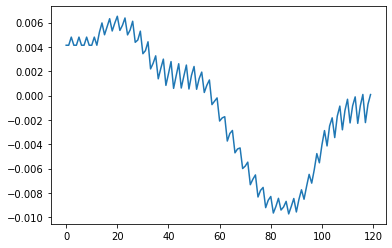

In [394]:
plt.figure()
plt.plot(ssn_yy2)

1.012143832405866
1.012143832405866
2.1987492659447065
3.2108930983505726
2.200857125921421
5.4117502242719935
[0.60130558 0.52181327 0.49553833 0.52548534 0.51660381 0.54597472
 0.53312465 0.57032355 0.56501129 0.57056958 0.54757014 0.5914655
 0.59927783 0.52052214 0.52637763 0.53424524 0.56541141 0.57070527
 0.54950169 0.53683925 0.56275157 0.56439459 0.60473189 0.62024288
 0.59297871 0.59510465 0.5997761  0.59637384 0.58534985 0.58472912
 0.58410839 0.59505615 0.53473249 0.58526961 0.5972645  0.60954675
 0.58772313 0.62803039 0.57089825 0.61562311 0.63031058 0.53452864
 0.53314729 0.53352955 0.51435176 0.53346119 0.54864077 0.57214448
 0.59573539 0.6317311  0.5870553  0.56537912 0.49769087 0.51111702
 0.53956022 0.56434823 0.58254976 0.63889696 0.57763275 0.57993039
 0.57390952 0.57027186 0.58177006 0.59240696 0.60304387 0.63763302
 0.61322165 0.56236872 0.55764187 0.53111161 0.52021343 0.57355006
 0.56342413 0.57175857 0.59188061 0.58115627 0.54547472 0.55901187
 0.52757631 0.50371

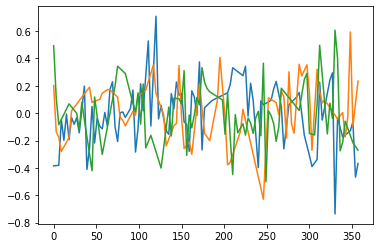

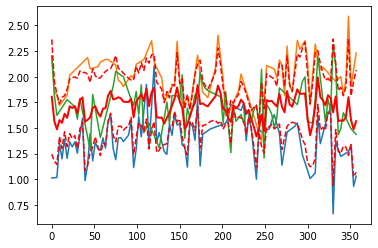

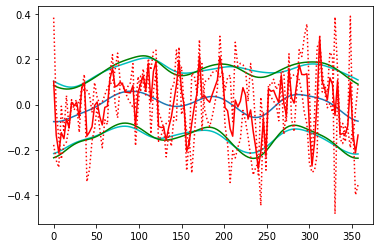

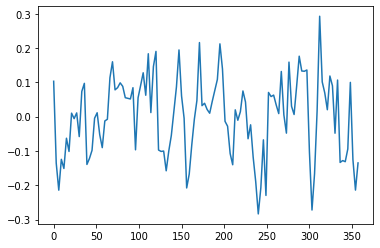

In [299]:
nmean = np.zeros([120,1])
yfuncmean = np.zeros([120,1])
for ny in range(0,3):
    yplot = np.squeeze(yy_interp[ny*120:(ny+1)*120])-np.squeeze(yfunc[ny*120:(ny+1)*120])
    plt.plot(xx_interp[0*120:(1)*120],yplot-np.nanmean(yplot))
    #print(yplot)
    nmean = np.squeeze(nmean) + np.squeeze(yplot)
    print(yplot[0])
    print(nmean[0])
    #yfuncmean = yfuncmean + yfunc[ny*120:(ny+1)*120]
nmean = nmean/3
nstd = np.zeros([120,1])
for ny in range(0,120):
    yplot = np.squeeze(yy_interp[np.arange(ny,120*3,120)])-np.squeeze(yfunc[np.arange(ny,120*3,120)])
    nstd[ny,0] = np.nanstd(yplot)
nstd = np.squeeze(nstd)

plt.figure()
for ny in range(0,3):
    plt.plot(xx_interp[0*120:(1)*120],yy_interp[ny*120:(ny+1)*120]-yfunc[ny*120:(ny+1)*120])
plt.plot(xx_interp[0*120:(1)*120],nmean,linewidth=2,color='r')
plt.plot(xx_interp[0*120:(1)*120],nmean+nstd,color='r',linestyle='--')
plt.plot(xx_interp[0*120:(1)*120],nmean-nstd,color='r',linestyle='--')

plt.figure()

plt.plot(xx_comp,yy_comp)
plt.plot(xx_comp,yy_std_lo,'c')
plt.plot(xx_comp,yy_std_hi,'c')
plt.plot(xx_comp,yy_comp+yy_std,'g')
plt.plot(xx_comp,yy_comp-yy_std,'g')
plt.plot(xx_comp,nmean-np.nanmean(nmean),'r')
plt.plot(xx_comp,nmean+nstd-np.nanmean(nmean+nstd),'r:')
plt.plot(xx_comp,nmean-nstd-np.nanmean(nmean-nstd),'r:')
print(nmean/3)

plt.figure()
plt.plot(xx_comp,yy_comp_a)

(120,)
(120,)


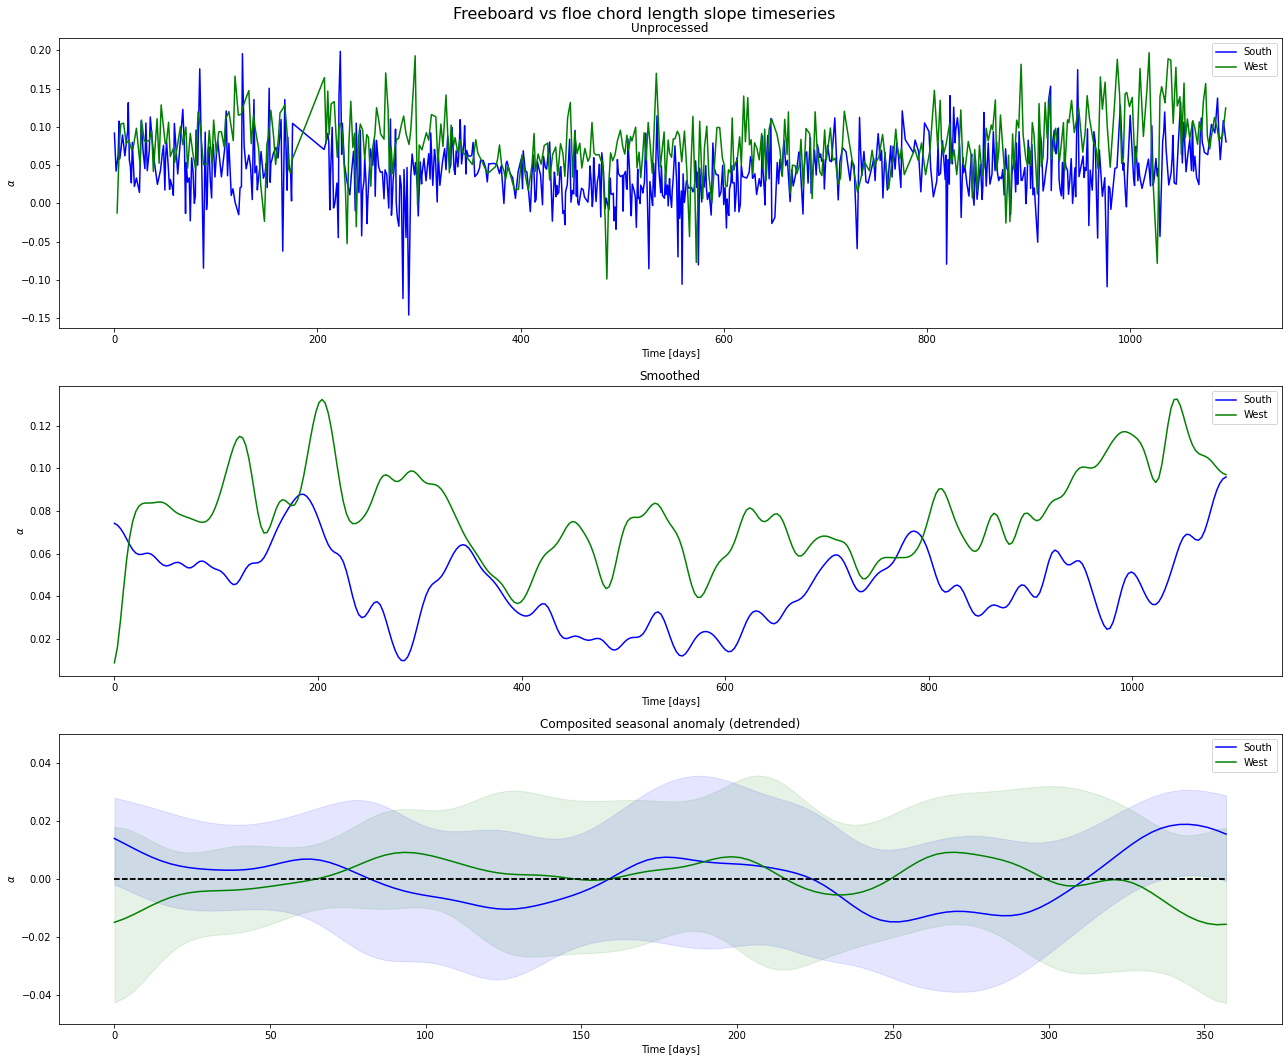

In [407]:
# Freeboard vs floe chord length slope timeseries
path = 'data/Array/'
regions_all = ['South','West']
years_all = [2019,2020,2021]
nyears = len(years_all)
nregions = len(regions_all)
nbins = 134 # Hard coded from the data (len(floe_chord_bin_means))
# ngroups = np.shape(mth_groups)[0]
fb_CL_slopes = [[],[]]
day_numbers = [[],[]]
ref_date = date(2019, 1, 1)
#
# Looping through regions
for iregion in range(nregions):
    # Looping through years
    for iyear in range(nyears): 
        # Loading data
        file_name = path + 'fb_chord_' + regions_all[iregion] + '_' + str(years_all[iyear]) + '.pkl'
        open_file = open(file_name, "rb")
        [mth_all, day_all, floe_chord_bin_means, floe_fb_mean_all] = pickle.load(open_file)
        open_file.close()
        #
        # Creating chunk
        chunk_fb = np.zeros(nbins)
        chunk_day = 0
        chunk_cnt = 0
        chunk_thresh = 3
        # Looping through all days and calculating slopes for chunks of ~ 10 days
        for iday in range(len(day_all)): 
            # Checking if data is available
            if (~np.isnan(mth_all[iday])):
                chunk_fb += floe_fb_mean_all[:,iday]
                my_date = date(years_all[iyear], int(mth_all[iday]), int(day_all[iday])) - ref_date
                chunk_day += my_date.days
                chunk_cnt += 1
                #
                if chunk_cnt == chunk_thresh:
                    # Getting date
                    my_date = date(years_all[iyear], int(mth_all[iday]), int(day_all[iday])) - ref_date
                    day_numbers[iregion].append(chunk_day/chunk_thresh)
                    # Getting slope
                    xx = floe_chord_bin_means
                    yy = chunk_fb/chunk_thresh
                    alpha,_ = np.polyfit(np.log10(xx), yy, 1)
                    fb_CL_slopes[iregion].append(alpha)
                    #
                    chunk_fb = np.zeros(nbins)
                    chunk_day = 0
                    chunk_cnt = 0

# Plotting
labels_all = ['South','West','Combined']
nn = int(np.floor(360/chunk_thresh))
nlabels = len(labels_all)   
#
ninterp = int(floor(nyears*364/chunk_thresh))
#
FFCL_slope_x = np.zeros((ninterp+1,nlabels))   
FFCL_slope_y = np.zeros((ninterp+1,nlabels))  
FFCL_slope_seas_x = np.zeros((nn,nlabels))   
FFCL_slope_seas_y = np.zeros((nn,nlabels))  
# 
fig = plt.figure(figsize = (18, 15))
fig.suptitle("Freeboard vs floe chord length slope timeseries", fontsize=16)
ax = fig.add_subplot(3,1,1)
ax = fig.add_subplot(3,1,2)
ax = fig.add_subplot(3,1,3)
for iregion in range(nregions):
    # Getting data
    if iregion < nregions:
        xx = day_numbers[iregion]
        yy = np.array(fb_CL_slopes[iregion])
    else:
        #xx = np.sum(day_numbers)
        #yy = np.array(np.sum(fb_CL_slopes))
        daynums_fullint = np.linspace(0,chunk_thresh*ninterp,num=ninterp+1)
        interpolant1 = interpolate.interp1d(day_numbers[0], np.array(fb_CL_slopes)[0],fill_value="extrapolate")
        interpolant2 = interpolate.interp1d(day_numbers[1], np.array(fb_CL_slopes)[1],fill_value="extrapolate")
        yy1_interp = interpolant1(daynums_fullint)
        yy2_interp = interpolant2(daynums_fullint)
        xx = daynums_fullint*1
        yy = (yy1_interp+yy2_interp)/2
    
    # No processing
    plt.subplot(3,1,1)
    yy[yy > 0.2] = np.NaN
    yy[yy < -0.2] = np.NaN
    yy = pd.Series(yy).interpolate().fillna(method='bfill').to_numpy()
    plt.plot(xx,yy,label=labels_all[iregion],c=reg_cols[iregion])
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Unprocessed')
    plt.legend()
    #
    # Interpolated
    plt.subplot(3,1,2)
    ninterp = int(floor(xx[-1]/chunk_thresh))
    xx_interp = np.linspace(0,chunk_thresh*ninterp,num=ninterp+1)
    interpolant = interpolate.interp1d(xx, yy,fill_value="extrapolate")
    yy_interp = interpolant(xx_interp)
    yy_smooth = gaussian_filter1d(yy_interp,3)
    plt.plot(xx_interp,yy_smooth,label=labels_all[iregion],c=reg_cols[iregion])
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Smoothed')
    plt.legend()
    yfunc = []
    for yr in range(0,3):
        slope,intercept,c,d,e = scipy.stats.linregress(xx_interp[yr*120:(yr+1)*120],yy_interp[yr*120:(yr+1)*120])
        yfunc = np.append(yfunc,slope*np.squeeze(xx_interp[yr*120:(yr+1)*120])+intercept)
    
    #
    # Composite and smoothing
    plt.subplot(3,1,3)
    xx_comp, yy_comp, yy_std = get_year_composite(xx_interp,yy_interp)
    yy_comp = get_periodic_smoothing(yy_comp,4)
    yy_std_lo = get_periodic_smoothing(yy_comp-yy_std,4)
    yy_std_hi = get_periodic_smoothing(yy_comp+yy_std,4)
    plt.plot(xx_comp,yy_comp,label=labels_all[iregion],c=reg_cols[iregion])
    plt.fill_between(xx_comp,yy_std_lo,yy_std_hi,color=reg_cols[iregion],alpha=0.1)
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Composited seasonal anomaly (detrended)')
    plt.ylim([-0.05,0.05])
    plt.plot(xx_comp,0*xx_comp,'k--')
    plt.legend()
    # Saving data
    FFCL_slope_x[:,iregion] = xx_interp 
    FFCL_slope_y[:,iregion] = yy_interp 
    FFCL_slope_seas_x[:,iregion] = xx_comp 
    FFCL_slope_seas_y[:,iregion] = yy_comp 
fig.tight_layout()     

plt.savefig('plots/FFCL_seas_timeseries.pdf')  

-0.2968567404634357
-0.2968567404634357
-0.0551244946057542
-0.3519812350691899
-0.026870219510876564
-0.3788514545800664
[-0.04209461 -0.03245289 -0.02457026 -0.02633944 -0.0310515  -0.02867296
 -0.02598021 -0.02523712 -0.02897716 -0.0233447  -0.02776572 -0.02855764
 -0.02556758 -0.03200719 -0.02681032 -0.02960048 -0.02501188 -0.02565298
 -0.02257489 -0.02852678 -0.03097179 -0.02497727 -0.02200366 -0.02747811
 -0.02813447 -0.02247807 -0.03041971 -0.02758889 -0.02201378 -0.01287843
 -0.02359403 -0.015886   -0.02797604 -0.02283126 -0.02238288 -0.0255182
 -0.02851589 -0.01989989 -0.01942492 -0.02804289 -0.01894329 -0.03125003
 -0.03590077 -0.02490598 -0.01968044 -0.028551   -0.01818015 -0.02403395
 -0.02724311 -0.02918793 -0.02816664 -0.01737478 -0.0280106  -0.03873737
 -0.03271735 -0.02052842 -0.01836673 -0.02147659 -0.01584466 -0.03037638
 -0.02817103 -0.03044741 -0.02521797 -0.02955057 -0.02240482 -0.01900208
 -0.02019981 -0.01255813 -0.024004   -0.0239727  -0.02064474 -0.03890392
 -0

(-0.1, 0.1)

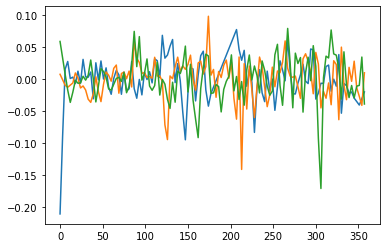

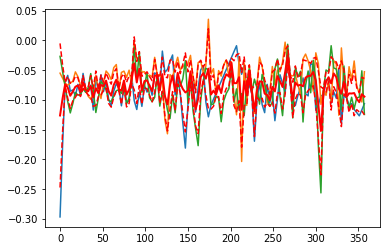

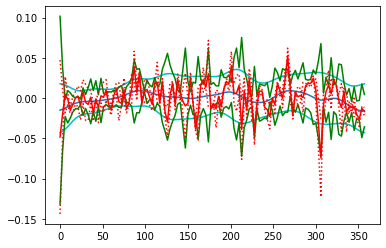

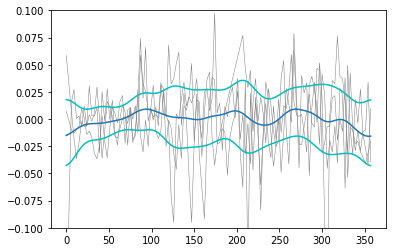

In [408]:
nmean = np.zeros([120,1])
yfuncmean = np.zeros([120,1])
for ny in range(0,3):
    yplot = np.squeeze(yy_interp[ny*120:(ny+1)*120])-np.squeeze(yfunc[ny*120:(ny+1)*120])
    plt.plot(xx_interp[0*120:(1)*120],yplot-np.nanmean(yplot))
    #print(yplot)
    nmean = np.squeeze(nmean) + np.squeeze(yplot)
    print(yplot[0])
    print(nmean[0])
    #yfuncmean = yfuncmean + yfunc[ny*120:(ny+1)*120]
nmean = nmean/3
nstd = np.zeros([120,1])
for ny in range(0,120):
    yplot = np.squeeze(yy_interp[np.arange(ny,120*3,120)])-np.squeeze(yfunc[np.arange(ny,120*3,120)])
    nstd[ny,0] = np.nanstd(yplot)
nstd = np.squeeze(nstd)

plt.figure()
for ny in range(0,3):
    plt.plot(xx_interp[0*120:(1)*120],yy_interp[ny*120:(ny+1)*120]-yfunc[ny*120:(ny+1)*120])
plt.plot(xx_interp[0*120:(1)*120],nmean,linewidth=2,color='r')
plt.plot(xx_interp[0*120:(1)*120],nmean+nstd,color='r',linestyle='--')
plt.plot(xx_interp[0*120:(1)*120],nmean-nstd,color='r',linestyle='--')

plt.figure()

plt.plot(xx_comp,yy_comp)
plt.plot(xx_comp,yy_std_lo,'c')
plt.plot(xx_comp,yy_std_hi,'c')
plt.plot(xx_comp,yy_comp+yy_std,'g')
plt.plot(xx_comp,yy_comp-yy_std,'g')
plt.plot(xx_comp,nmean-np.nanmean(nmean),'r')
plt.plot(xx_comp,nmean+nstd-np.nanmean(nmean+nstd),'r:')
plt.plot(xx_comp,nmean-nstd-np.nanmean(nmean-nstd),'r:')
print(nmean/3)

plt.figure()
for ny in range(0,3):
    yplot = np.squeeze(yy_interp[ny*120:(ny+1)*120])-np.squeeze(yfunc[ny*120:(ny+1)*120])
    plt.plot(xx_interp[0*120:(1)*120],yplot-np.nanmean(yplot),color='grey',linewidth=0.5)
plt.plot(xx_comp,yy_comp)
plt.plot(xx_comp,yy_std_lo,'c')
plt.plot(xx_comp,yy_std_hi,'c')
plt.ylim([-0.1,0.1])

(120,)
(120,)


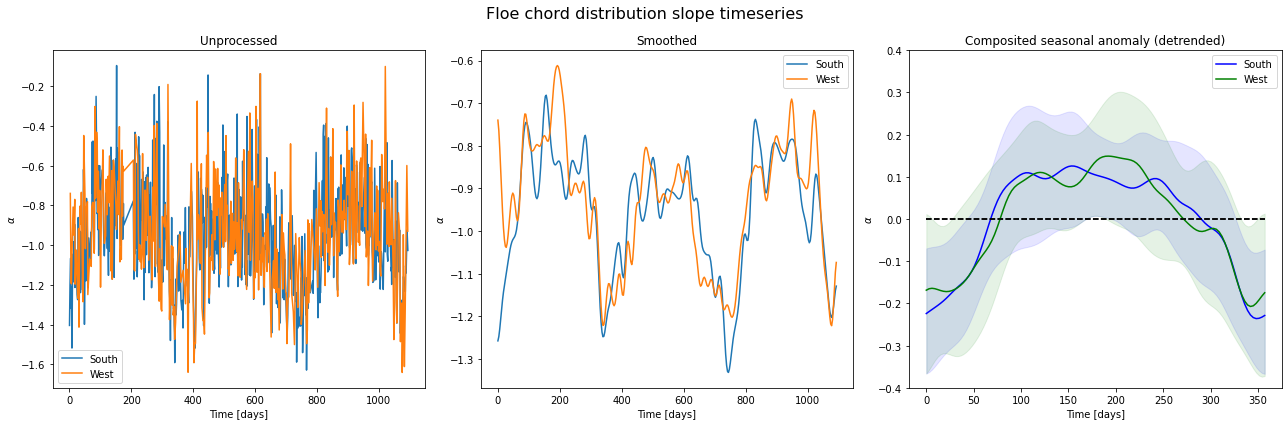

In [409]:
# Floe chord distribution slope timeseries
path = 'data/Array/'
regions_all = ['South','West']
years_all = [2019,2020,2021]
nyears = len(years_all)
nregions = len(regions_all)
nbins = 999 # Hard coded from the data (len(floe_chord_bin_means))
FCD_slopes = [[],[]]
day_numbers = [[],[]]
ref_date = date(2019, 1, 1)
#
# Looping through regions
for iregion in range(nregions):
    # Looping through years
    for iyear in range(nyears): 
        # Loading data
        file_name = path + 'FSD_' + regions_all[iregion] + '_' + str(years_all[iyear]) + '.pkl'
        open_file = open(file_name, "rb")
        [mth_all, FSD_all, floe_chord_bin_means, floe_chord_lengths_all_beams] = pickle.load(open_file)
        open_file.close()
        #
        # Attempting to get day_all
        file_name = path + 'fb_chord_' + regions_all[iregion] + '_' + str(years_all[iyear]) + '.pkl'
        open_file = open(file_name, "rb")
        [_, day_all, _, _] = pickle.load(open_file)
        open_file.close()
        #
        # Creating chunk
        chunk_fb = np.zeros(nbins)
        chunk_day = 0
        chunk_cnt = 0
        chunk_thresh = 3
        # Looping through all days and calculating slopes for chunks of ~ 10 days
        for iday in range(len(day_all)): 
            # Checking if data is available
            if (~np.isnan(day_all[iday])):
                chunk_fb += FSD_all[:,iday]
                my_date = date(years_all[iyear], int(mth_all[iday]), int(day_all[iday])) - ref_date
                chunk_day += my_date.days
                chunk_cnt += 1
                #
                if chunk_cnt == chunk_thresh:
                    # Getting date
                    my_date = date(years_all[iyear], int(mth_all[iday]), int(day_all[iday])) - ref_date
                    day_numbers[iregion].append(chunk_day/chunk_thresh)
                    # Getting slope
                    xx = floe_chord_bin_means
                    yy = chunk_fb/chunk_thresh
                    idx = np.argwhere(yy > 0.)
                    idx = np.reshape(idx,(len(idx)))
                    xx = xx[idx]
                    yy = yy[idx]
                    alpha,_ = np.polyfit(np.log10(xx), np.log10(yy), 1)
                    FCD_slopes[iregion].append(alpha)
                    #
                    chunk_fb = np.zeros(nbins)
                    chunk_day = 0
                    chunk_cnt = 0
                    
              
# Plotting
labels_all = ['South','West','Combined']
nn = int(np.floor(360/chunk_thresh))
nlabels = len(labels_all)   
#
ninterp = int(floor(nyears*364/chunk_thresh))
#
FCD_slope_x = np.zeros((ninterp+1,nlabels))   
FCD_slope_y = np.zeros((ninterp+1,nlabels))  
FCD_slope_seas_x = np.zeros((nn,nlabels))   
FCD_slope_seas_y = np.zeros((nn,nlabels))  
FCD_slope_seas_y_stdlo = np.zeros((nn,nlabels)) 
FCD_slope_seas_y_stdhi = np.zeros((nn,nlabels)) 
#
fig = plt.figure(figsize = (18, 6))
fig.suptitle("Floe chord distribution slope timeseries", fontsize=16)
ax = fig.add_subplot(1,3,1)
ax = fig.add_subplot(1,3,2)
ax = fig.add_subplot(1,3,3)
for iregion in range(nregions):
    # No processing
    plt.subplot(1,3,1)
    xx = day_numbers[iregion]
    yy = np.array(FCD_slopes[iregion])
    yy = pd.Series(yy).interpolate().fillna(method='bfill').to_numpy()
    plt.plot(xx,yy,label=regions_all[iregion])
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Unprocessed')
    plt.legend()
    #
    # Interpolated
    plt.subplot(1,3,2)
    ninterp = int(floor(xx[-1]/chunk_thresh))
    xx_interp = np.linspace(0,chunk_thresh*ninterp,num=ninterp+1)
    interpolant = interpolate.interp1d(xx, yy,fill_value="extrapolate")
    yy_interp = interpolant(xx_interp)
    yy_smooth = gaussian_filter1d(yy_interp,3)
    plt.plot(xx_interp,yy_smooth,label=regions_all[iregion])
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Smoothed')
    plt.legend()
    #
    # Composite and smoothing
    plt.subplot(1,3,3)
    xx_comp, yy_comp,yy_std = get_year_composite(xx_interp,yy_interp)
    yy_comp = get_periodic_smoothing(yy_comp,4)
    yy_std_lo = get_periodic_smoothing(yy_comp+yy_std,4)
    yy_std_hi = get_periodic_smoothing(yy_comp-yy_std,4)
    plt.plot(xx_comp,yy_comp,label=regions_all[iregion],color=reg_cols[iregion])
    yy_std_lo = get_periodic_smoothing(yy_comp-yy_std,4)
    yy_std_hi = get_periodic_smoothing(yy_comp+yy_std,4)
    plt.fill_between(xx_comp,yy_std_lo,yy_std_hi,color=reg_cols[iregion],alpha=0.1)
    plt.ylim([-0.4,0.4])
    plt.xlabel('Time [days]')
    plt.ylabel(r'$\alpha$')
    plt.title('Composited seasonal anomaly (detrended)')
    plt.plot(xx_comp,0*xx_comp,'k--')
    plt.legend()
    #
    # Saving data
    FCD_slope_x[:,iregion] = xx_interp 
    FCD_slope_y[:,iregion] = yy_interp 
    FCD_slope_seas_x[:,iregion] = xx_comp 
    FCD_slope_seas_y[:,iregion] = yy_comp 
    FCD_slope_seas_y_stdlo[:,iregion] = yy_std_lo 
    FCD_slope_seas_y_stdhi[:,iregion] = yy_std_hi 
fig.tight_layout()
plt.savefig('plots/FCD_seas_timeseries.pdf')  

<ipython-input-489-261531eeaf79>:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_vals = np.squeeze(np.array(day_numbers)[iregion][isize])


(4320,)
[   1    2    3 ... 1437 1438 1439]
[1440 1441 1442 ... 2877 2878 2879]
[2880 2881 2882 ... 4316 4317 4318]
(12,)
(4320,)
[   1    2    3 ... 1437 1438 1439]
[1440 1441 1442 ... 2877 2878 2879]
[2880 2881 2882 ... 4316 4317 4318]
(12,)
(4320,)
[   1    2    3 ... 1437 1438 1439]
[1440 1441 1442 ... 2877 2878 2879]
[2880 2881 2882 ... 4316 4317 4318]
(12,)
(4320,)
[   1    2    3 ... 1437 1438 1439]
[1440 1441 1442 ... 2877 2878 2879]
[2880 2881 2882 ... 4316 4317 4318]
(12,)
(4320,)
[   1    2    3 ... 1437 1438 1439]
[1440 1441 1442 ... 2877 2878 2879]
[2880 2881 2882 ... 4316 4317 4318]
(12,)
(4320,)
[   1    2    3 ... 1437 1438 1439]
[1440 1441 1442 ... 2877 2878 2879]
[2880 2881 2882 ... 4316 4317 4318]
(12,)


<ipython-input-489-261531eeaf79>:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  interpolant1 = interpolate.interp1d(day_numbers[0][isize], np.array(floe_profile_squareness)[0][isize],
<ipython-input-489-261531eeaf79>:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  interpolant2 = interpolate.interp1d(day_numbers[1][isize], np.array(floe_profile_squareness)[1][isize],


IndexError: index 2 is out of bounds for axis 0 with size 2

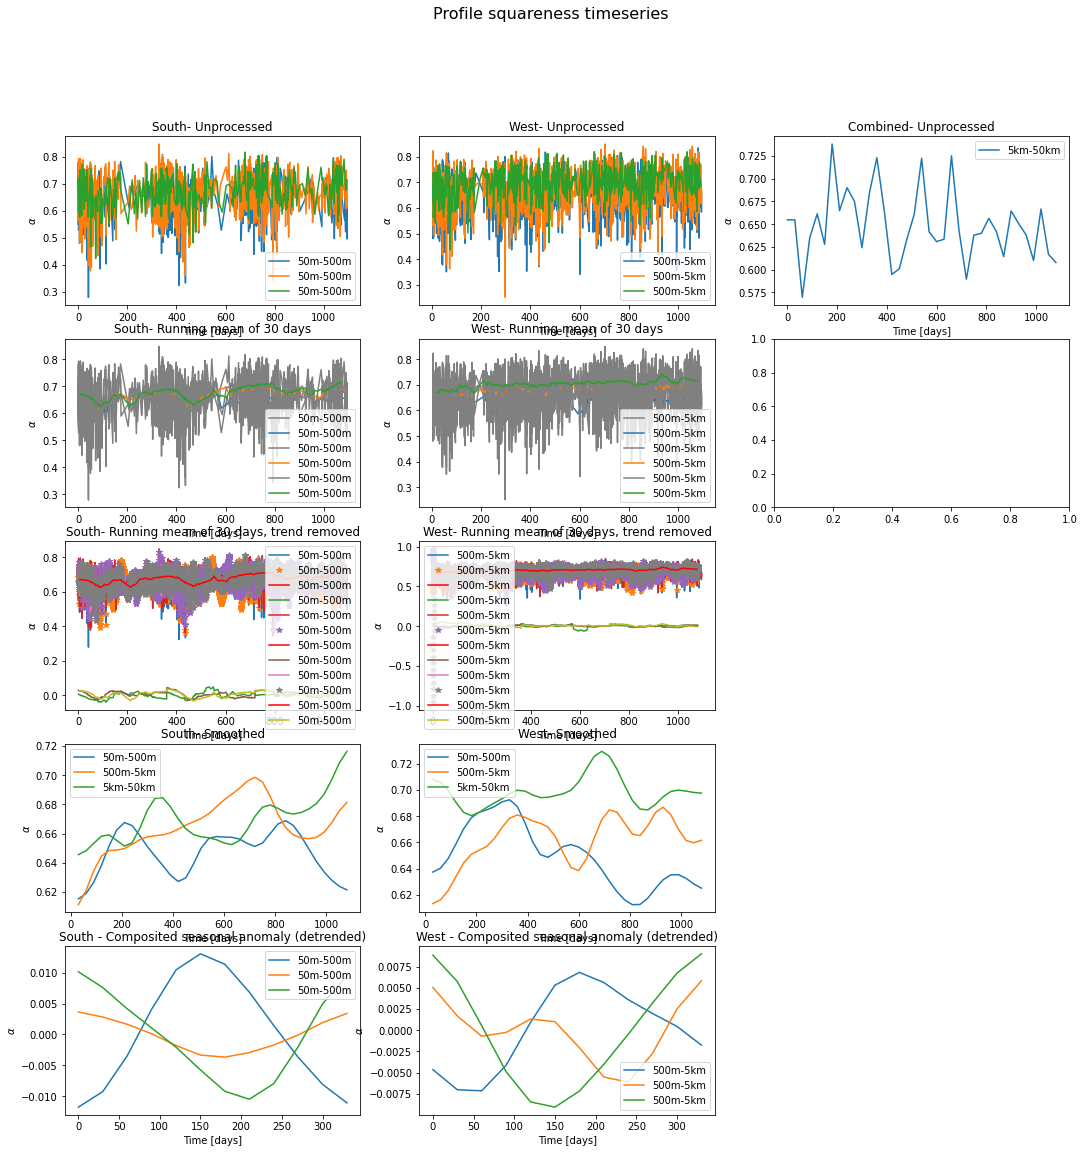

In [489]:
import scipy

# Floe profiles timeseries
path = 'data/Array/'
regions_all = ['South','West']
size_ranges = [50, 500, 5000, 50000]
size_all = ['50m-500m','500m-5km','5km-50km']
nsize = len(size_all)
years_all = [2019,2020,2021]
nyears = len(years_all)
nregions = len(regions_all)
nbins = 50 # Hard coded from the data 
# ngroups = np.shape(mth_groups)[0]
floe_profile_squareness = [[[],[],[]],[[],[],[]]]
day_numbers = [[[],[],[]],[[],[],[]]]
ref_date = date(2019, 1, 1)
#
# Looping through regions
for iregion in range(nregions):
    # Looping through years
    for iyear in range(nyears): 
        # Loading data
        file_name = path + 'floe_profiles_' + regions_all[iregion] + '_' + str(years_all[iyear]) + '.pkl'
        open_file = open(file_name, "rb")
        [floe_months_fb, floe_days_fb, floe_profiles, floe_chord_lengths, floe_fb] = pickle.load(open_file)
        open_file.close()
        #
        # Looping through floe sizes (small,med,large)
        for isize in range(nsize):
            # Getting floes of the right size
            idx1 = np.where( (floe_chord_lengths >= size_ranges[isize]) )[0]
            idx2 = np.where( (floe_chord_lengths < size_ranges[isize+1]) )[0] 
            idx = np.intersect1d(idx1, idx2)
            sized_days = floe_days_fb[idx]
            sized_months = floe_months_fb[idx]
            sized_profiles = floe_profiles[:,idx]
            #
            # Creating chunk
            chunk_profile = np.zeros(nbins)
            chunk_day = 0
            chunk_cnt = 0
            chunk_thresh = 30
            # Looping through all days and calculating for chunks of ~ 10 days
            for iday in range(len(sized_days)): 
                # Checking if data is available
                if (~np.isnan(sized_days[iday])):
                    chunk_profile += sized_profiles[:,iday]
                    my_date = date(years_all[iyear], int(sized_months[iday]), int(sized_days[iday])) - ref_date
                    chunk_day += my_date.days
                    chunk_cnt += 1
                    #
                    if chunk_cnt == chunk_thresh:
                        # Getting date
                        day_numbers[iregion][isize].append(chunk_day/chunk_thresh)
                        # Getting 'squareness' 
                        yy = chunk_profile/chunk_thresh
                        yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) 
                        squareness = get_vsquareness(yy_norm)
                        floe_profile_squareness[iregion][isize].append(squareness)
                        # Resetting chunks
                        chunk_profile = np.zeros(nbins)
                        chunk_day = 0
                        chunk_cnt = 0          


                        
# Plotting
labels_all = ['South','West','Combined']
nn = int(np.floor(360/chunk_thresh))
nlabels = len(labels_all)   
#
ninterp = int(floor(nyears*364/chunk_thresh))
#
FPS_x = np.zeros((ninterp,nlabels,nsize))   
FPS_y = np.zeros((ninterp,nlabels,nsize))  
FPS_seas_x = np.zeros((nn,nlabels,nsize))   
FPS_seas_y = np.zeros((nn,nlabels,nsize))  
# 
fig = plt.figure(figsize = (18,18))
fig.suptitle("Profile squareness timeseries", fontsize=16)
# Looping through regions
for iregion in range(nlabels):
    for isize in range(nsize):
        # Getting data
        if iregion < nregions:
            xx = day_numbers[iregion][isize]
            yy = np.array(floe_profile_squareness[iregion][isize])
        else:
            #xx = []
            #yy = []
            #for ii in range(nregions):
            #    xx = np.append(xx,day_numbers[ii][isize])
            #    print(day_numbers[ii][isize])
            #    yy = np.append(yy,floe_profile_squareness[ii][isize])
            daynums_fullint = np.linspace(0,chunk_thresh*ninterp,num=ninterp+1)
            interpolant1 = interpolate.interp1d(day_numbers[0][isize], np.array(floe_profile_squareness)[0][isize],
                                                fill_value="extrapolate")
            interpolant2 = interpolate.interp1d(day_numbers[1][isize], np.array(floe_profile_squareness)[1][isize],
                                                fill_value="extrapolate")
            yy1_interp = interpolant1(daynums_fullint)
            yy2_interp = interpolant2(daynums_fullint)
            xx = daynums_fullint*1
            yy = (yy1_interp+yy2_interp)/2
        
        #cnt_plt = iregion*4 + 1
        cnt_plt = iregion+1
        # No processing
        plt.subplot(5,3,cnt_plt)
        yy = pd.Series(yy).interpolate().fillna(method='bfill').to_numpy()
        plt.plot(xx,yy,label=size_all[iregion])
        #slope,intercept,rvalue,pvalue,stderr = scipy.stats.linregress(xx,yy)
        #plt.plot(xx,slope*np.squeeze(xx)+intercept,linewidth=2)
        plt.xlabel('Time [days]')
        plt.ylabel(r'$\alpha$')
        plt.title(labels_all[iregion] + '- Unprocessed')
        plt.legend()
        cnt_plt += nlabels
        #
        # Running mean
        plt.subplot(5,3,cnt_plt)
        yy2 = np.nan*np.ones(np.shape(yy))
        rmean_days = 30
        for dd in range(int(rmean_days/2),len(yy2)-int(rmean_days/2)+1):
            arr_vals = np.squeeze(np.array(day_numbers)[iregion][isize])
            this_day = arr_vals[dd]
            ind = np.where((arr_vals<(this_day+rmean_days))&(arr_vals>(this_day-rmean_days)))[0]
            #print(np.nanmean(yy[ind]))
            yy2[dd] = np.nanmean(yy[ind])
        plt.plot(xx,yy,label=size_all[iregion],color='grey')
        plt.plot(xx,yy2,label=size_all[iregion])
        plt.xlabel('Time [days]')
        plt.ylabel(r'$\alpha$')
        plt.title(labels_all[iregion] + '- Running mean of '+str(rmean_days)+' days')
        plt.legend()
        cnt_plt += nlabels
        #
        # Running mean, remove year
        plt.subplot(5,3,cnt_plt)
        len_yr = 360*12
        xx_interp = np.linspace(0,360*3,num=len_yr)
        print(np.shape(xx_interp))
        interpolant = interpolate.interp1d(xx, yy,fill_value="extrapolate")
        yy_interp = interpolant(xx_interp)
        interpolant = interpolate.interp1d(xx, yy2,fill_value="extrapolate")
        yy2_interp = interpolant(xx_interp)
        yy2_trend = []
        plt.plot(xx,yy,label=size_all[iregion])
        plt.plot(xx_interp,yy_interp,'*',label=size_all[iregion])
        plt.plot(xx_interp,yy2_interp,'r',label=size_all[iregion])
        #print(np.shape(yy))
        yn = len_yr
        final_ind = []
        for ii in range(0,3):
            ind = np.where((xx_interp>(ii*360))&(xx_interp<(ii+1)*360))[0]
            print(ind)
            xin = xx_interp[ind]*1
            yin = yy_interp[ind]*1
            slope,intercept,rvalue,pvalue,stderr = scipy.stats.linregress(xin,yin)
            yy2_trend = np.append(yy2_trend,slope*np.squeeze(np.array(xx_interp[ind]))+intercept)
            for nn in range(0,len(ind)):
                final_ind = np.append(final_ind,int(ind[nn]))
        plt.plot(xx_interp[final_ind.astype(int)],yy2_interp[final_ind.astype(int)]-yy2_trend,label=size_all[iregion])
        plt.xlabel('Time [days]')
        plt.ylabel(r'$\alpha$')
        plt.title(labels_all[iregion] + '- Running mean of '+str(rmean_days)+' days, trend removed')
        plt.legend()
        cnt_plt += nlabels
        
        # Interpolated
        plt.subplot(5,3,cnt_plt)
        xx_interp = np.linspace(chunk_thresh,chunk_thresh*ninterp,num=ninterp)
        interpolant = interpolate.interp1d(xx, yy,fill_value="extrapolate")
        yy_interp = interpolant(xx_interp)
        yy_interp = pd.Series(yy_interp).interpolate().fillna(method='bfill').to_numpy()
        yy_smooth = gaussian_filter1d(yy_interp,2)
        plt.plot(xx_interp,yy_smooth,label=size_all[isize])
        plt.xlabel('Time [days]')
        plt.ylabel(r'$\alpha$')
        plt.title(labels_all[iregion] + '- Smoothed')
        plt.legend()
        cnt_plt += nlabels
        #
        # Composite and smoothing
        plt.subplot(5,3,cnt_plt)
        xx_comp, yy_comp, yy_std = get_year_composite(xx_interp,yy_interp)
        yy_comp = get_periodic_smoothing(yy_comp,2)
        plt.plot(xx_comp,yy_comp,label=size_all[iregion])
        plt.xlabel('Time [days]')
        plt.ylabel(r'$\alpha$')
        plt.title(labels_all[iregion] + ' - Composited seasonal anomaly (detrended)')
        plt.legend()
        cnt_plt += nlabels
        #
        # Saving data
        FPS_x[:,iregion,isize] = xx_interp 
        FPS_y[:,iregion,isize] = yy_interp 
        FPS_seas_x[:,iregion,isize] = xx_comp 
        FPS_seas_y[:,iregion,isize] = yy_comp 
fig.tight_layout()
plt.savefig('plots/floe_squareness_seas_timeseries2.pdf')  

[0.0, 0.0, 0.23333333333333334, 1.0, 1.0, 1.0, 2.066666666666667, 3.066666666666667, 4.0, 4.0, 4.833333333333333, 5.0, 5.0, 5.0, 5.0, 5.633333333333334, 7.0, 7.0, 7.0, 7.166666666666667, 8.0, 8.0, 8.466666666666667, 9.0, 9.0, 11.4, 13.733333333333333, 15.0, 15.666666666666666, 16.2, 17.066666666666666, 18.0, 18.0, 18.666666666666668, 19.0, 19.066666666666666, 20.866666666666667, 21.766666666666666, 22.933333333333334, 25.966666666666665, 26.6, 27.0, 27.0, 28.566666666666666, 30.333333333333332, 31.0, 31.0, 31.033333333333335, 32.2, 35.53333333333333, 36.0, 36.0, 36.53333333333333, 38.0, 38.0, 41.53333333333333, 45.733333333333334, 48.0, 48.833333333333336, 49.0, 49.43333333333333, 50.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.9, 52.53333333333333, 53.06666666666667, 54.9, 55.63333333333333, 57.333333333333336, 58.0, 58.0, 58.8, 59.0, 59.8, 65.86666666666666, 68.0, 68.43333333333334, 70.46666666666667, 72.23333333333333, 76.0, 78.83333333333333, 79.0, 79.33333333333333, 80.4, 88.46666666666667

/Users/heareg/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/heareg/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
<ipython-input-305-d3eaba5c7f6f>:41: RuntimeWarning: Mean of empty slice
  yy2[ii] = np.nanmean(yy[ii-rmean_days:ii+rmean_days+1])


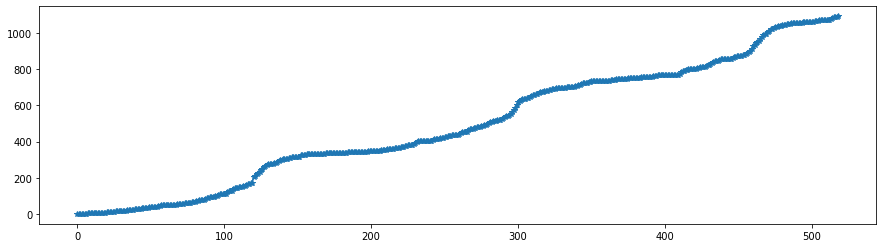

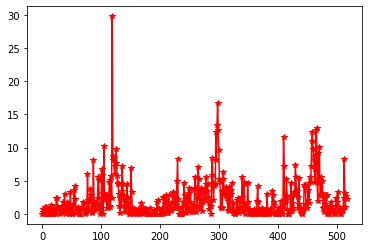

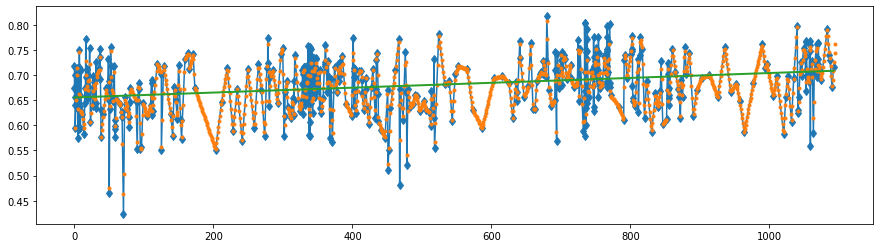

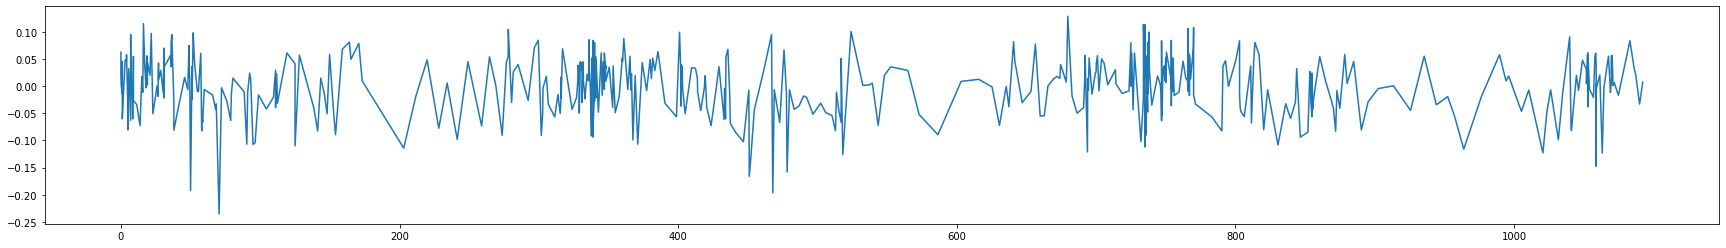

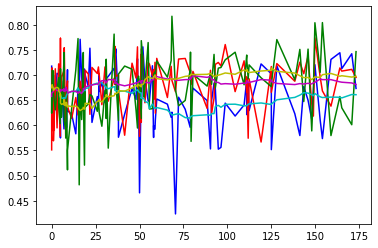

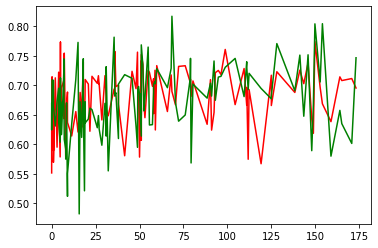

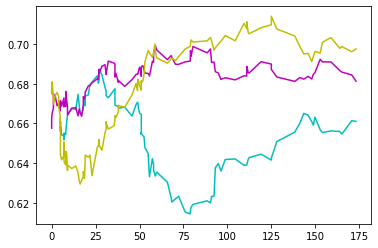

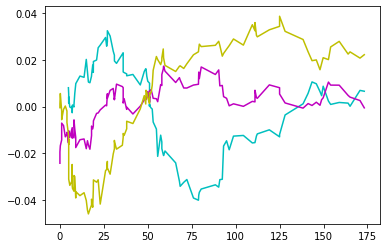

In [305]:
## Take an example
iregion=0
for isize in range(nsize):
        # Getting data
        if iregion < nregions:
            xx = day_numbers[iregion][isize]
            yy = np.array(floe_profile_squareness[iregion][isize])
        else:
            xx = []
            yy = []
            for ii in range(nregions):
                xx = np.append(xx,day_numbers[ii][isize])
                yy = np.append(yy,floe_profile_squareness[ii][isize])
        
plt.figure(figsize=(15,4))
plt.plot(xx,'*-')
plt.figure()
plt.plot(np.diff(xx),'r*-')
plt.figure(figsize=(15,4))
plt.plot(xx,yy,'d-')
print(xx)
xx_interp = np.linspace(0,1095,num=1095)#chunk_thresh*ninterp,num=ninterp+1)
yy = pd.Series(yy).interpolate().fillna(method='bfill').to_numpy()
interpolant = interpolate.interp1d(xx, yy,fill_value="extrapolate")
yy_interp = interpolant(xx_interp)
plt.plot(xx_interp,yy_interp,'.')

slope,intercept,rvalue,pvalue,stderr = scipy.stats.linregress(xx,yy)
plt.plot(xx,slope*np.squeeze(xx)+intercept,linewidth=2)

plt.figure(figsize=(30,4))
plt.plot(xx,yy-(slope*np.squeeze(xx)+intercept))
plt.figure()
plt.plot(xx[0:120],yy[0:120],'b')
plt.plot(xx[0:120],yy[120:240],'r')
plt.plot(xx[0:120],yy[240:360],'g')

yy2 = np.nan*np.ones(np.shape(yy))
rmean_days = 10
for ii in range(int(rmean_days/2),len(yy2)-int(rmean_days/2)+1):
    yy2[ii] = np.nanmean(yy[ii-rmean_days:ii+rmean_days+1])
plt.plot(xx[0:120],yy2[0:120],'c')
plt.plot(xx[0:120],yy2[120:240],'m')
plt.plot(xx[0:120],yy2[240:360],'y') 

plt.figure()
#plt.plot(xx[0:120],np.nanmean(np.reshape(yy,[120,3])),'b')
plt.plot(xx[0:120],yy[120:240],'r')
plt.plot(xx[0:120],yy[240:360],'g')

plt.figure()
plt.plot(xx[0:120],yy2[0:120],'c')
plt.plot(xx[0:120],yy2[120:240],'m')
plt.plot(xx[0:120],yy2[240:360],'y')    

plt.figure()
plt.plot(xx[0:120],yy2[0:120]-np.nanmean(yy2[0:120]),'c')
plt.plot(xx[0:120],yy2[120:240]-np.nanmean(yy2[120:240]),'m')
plt.plot(xx[0:120],yy2[240:360]-np.nanmean(yy2[240:360]),'y')  

print(xx)

/Users/heareg/opt/anaconda3/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/Users/heareg/opt/anaconda3/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))


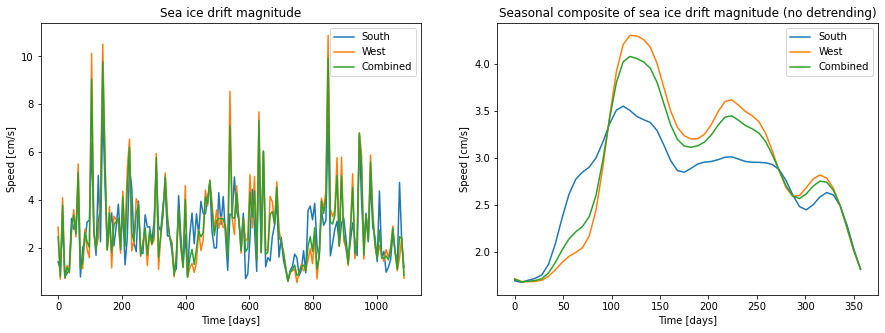

In [326]:
# Sea ice velocity magnitude (Polar Pathfinder)
ds = xr.open_mfdataset('data/icemotion_vectors/*.nc')

# West
ds_west = ds.where((ds['longitude'] > -65) & (ds['longitude'] < -45) & (ds['latitude'] >  -77.6) & (ds['latitude'] < -62))
umag_west = np.array(np.sqrt(ds_west['u']**2 + ds_west['v']**2)) 
weights_west = np.array(np.cos(np.deg2rad(ds_west['latitude'])))
umag_ts_west = np.array(np.nansum(umag_west * weights_west,axis=(1,2)) / np.nansum(weights_west,axis=(1,2))) 
#
# South
ds_south = ds.where((ds['longitude'] > -65) & (ds['longitude'] < -15) & (ds['latitude'] >  -77.6) & (ds['latitude'] < -73))
umag_south = np.array(np.sqrt(ds_south['u']**2 + ds_south['v']**2)) 
weights_south = np.array(np.cos(np.deg2rad(ds_south['latitude'])))
umag_ts_south = np.array(np.nansum(umag_south * weights_south,axis=(1,2)) / np.nansum(weights_south,axis=(1,2))) 
#
# Overall region
umag_ts_overall = (np.nansum(umag_south*weights_south,axis=(1,2)) + np.nansum(umag_west*weights_west,axis=(1,2))) / ( np.nansum(weights_south,axis=(1,2)) + np.nansum(weights_west,axis=(1,2)))      
umag_ts_overall = np.array(umag_ts_overall)
nweeks = len(umag_ts_overall)
nyears = 3
#
# Combining in one array
tt_umag = np.linspace(0, 7*(nweeks-1),num=nweeks) # time [days]
nregions = 3
umag = np.zeros((nweeks,nregions))
umag[:,0] = umag_ts_south
umag[:,1] = umag_ts_west
umag[:,2] = umag_ts_overall

# Getting seasonal composite
npoints = int(nweeks/nyears)
umag_seas_x = np.zeros((npoints,3))
umag_seas_y = np.zeros((npoints,3))
umag_seas_y_stdlo = np.zeros((npoints,3))
umag_seas_y_stdhi = np.zeros((npoints,3))
label_all = ['South','West','Combined']
fig = plt.figure(figsize = (15, 5))
for iregion in range(nregions):
    xx_comp, yy_comp, yy_std = get_year_composite_no_detrending(tt_umag,umag[:,iregion],365)
    yy_comp = get_periodic_smoothing(yy_comp,2)
    yy_comp_lo = get_periodic_smoothing(yy_comp-yy_std,2)
    yy_comp_hi = get_periodic_smoothing(yy_comp+yy_std,2)
    #
    plt.subplot(1,2,1)
    umag[:,0] = umag_ts_south
    umag[:,1] = umag_ts_west
    umag[:,2] = umag_ts_overall
    plt.plot(tt_umag,umag[:,iregion],label=label_all[iregion])
    plt.legend()
    plt.title('Sea ice drift magnitude')
    plt.xlabel('Time [days]')
    plt.ylabel('Speed [cm/s]')
    #
    plt.subplot(1,2,2)
    plt.plot(xx_comp,yy_comp,label=label_all[iregion])
    plt.legend()
    plt.title('Seasonal composite of sea ice drift magnitude (no detrending)')
    plt.xlabel('Time [days]')
    plt.ylabel('Speed [cm/s]')
    #
    # Saving data into array
    umag_seas_x[:,iregion] = xx_comp 
    umag_seas_y[:,iregion] = yy_comp 
    umag_seas_y_stdlo[:,iregion] = yy_comp_lo
    umag_seas_y_stdhi[:,iregion] = yy_comp_hi 

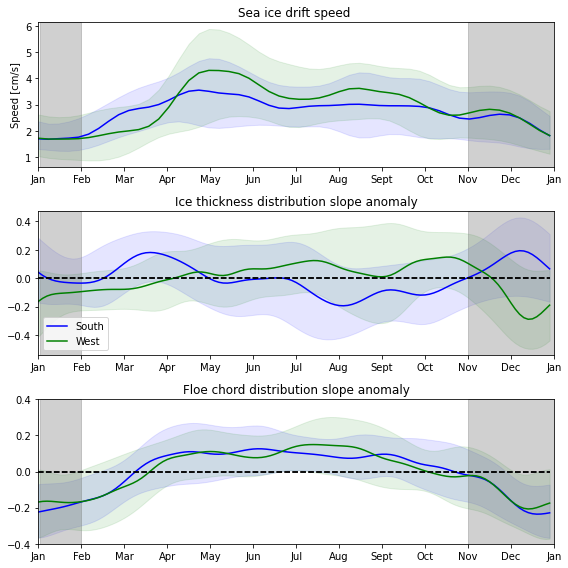

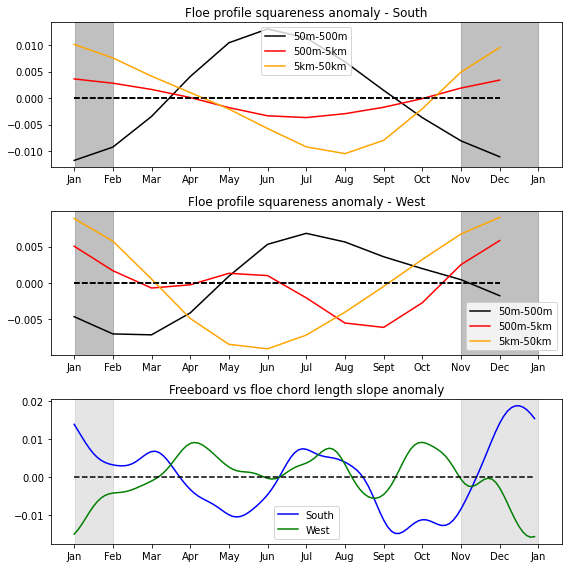

In [416]:
# All seasonal plots together
 

# Plotting
labels_all = ['South','West','Combined']
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Jan']

reg_cols = ['b','g']
size_cols = ['k','r','orange']

### FIGURE 2
fig = plt.figure(figsize = (8,8))
nsubplots = 3
nregions = 2
for iregion in range(nregions):
    #
    melt_box1_st = 30*10
    melt_box1_en = 360
    melt_box2_st = 1
    melt_box2_en = 30
    cnt_plt = 1
    #
    # Sea ice drift speed 
    ax = plt.subplot(nsubplots,1,cnt_plt)
    xx = umag_seas_x[:,iregion]
    yy = umag_seas_y[:,iregion]
    plt.plot(xx,yy,label=labels_all[iregion],c=reg_cols[iregion])
#     plt.plot(xx,xx*0,'k--')
    plt.fill_between(xx,umag_seas_y_stdlo[:,iregion],umag_seas_y_stdhi[:,iregion],
                     alpha=0.1,color=reg_cols[iregion])
    xticks_loc = np.linspace(0, 360, num=13)
    plt.xticks(xticks_loc, xlabels)
    ax.axvspan(melt_box1_st, melt_box1_en, alpha=0.2, color='grey')
    ax.axvspan(melt_box2_st, melt_box2_en, alpha=0.2, color='grey')
    plt.ylabel('Speed [cm/s]')
    plt.xlim([0,360])
    plt.title('Sea ice drift speed ')
    #plt.legend()
    cnt_plt += 1
    # ITD
    ax = plt.subplot(nsubplots,1,cnt_plt)
    xx = ITD_slope_seas_x[:,iregion]
    yy = ITD_slope_seas_y[:,iregion]
    plt.plot(xx,yy,label=labels_all[iregion],c=reg_cols[iregion])
    plt.fill_between(xx,ITD_slope_seas_y_stdlo[:,iregion],ITD_slope_seas_y_stdhi[:,iregion],
                     alpha=0.1,color=reg_cols[iregion])
    plt.plot(xx,xx*0,'k--')
    xticks_loc = np.linspace(0, 360, num=13)
    plt.xticks(xticks_loc, xlabels)
    ax.axvspan(melt_box1_st, melt_box1_en, alpha=0.2, color='grey')
    ax.axvspan(melt_box2_st, melt_box2_en, alpha=0.2, color='grey')
    plt.title('Ice thickness distribution slope anomaly')
    plt.xlim([0,360])
    plt.legend(loc='lower left')
    cnt_plt += 1
    #
    # FCD
    ax = plt.subplot(nsubplots,1,cnt_plt)
    xx = FCD_slope_seas_x[:,iregion]
    yy = FCD_slope_seas_y[:,iregion]
    plt.plot(xx,yy,label=labels_all[iregion],c=reg_cols[iregion])
    plt.fill_between(xx,FCD_slope_seas_y_stdlo[:,iregion],FCD_slope_seas_y_stdhi[:,iregion],
                     alpha=0.1,color=reg_cols[iregion])
    plt.ylim([-0.4,0.4])
    plt.plot(xx,xx*0,'k--')
    xticks_loc = np.linspace(0, 360, num=13)
    plt.xticks(xticks_loc, xlabels)
    ax.axvspan(melt_box1_st, melt_box1_en, alpha=0.2, color='grey')
    ax.axvspan(melt_box2_st, melt_box2_en, alpha=0.2, color='grey')
    plt.xlim([0,360])
    plt.title('Floe chord distribution slope anomaly')
    #plt.legend()
    cnt_plt += 1
    #

fig.tight_layout()     

plt.savefig('plots/fig2_freq.pdf')  


### FIGURE 3
fig = plt.figure(figsize = (8,8))
nsubplots = 3
nregions = 2
for iregion in range(nregions):
    #
    melt_box1_st = 30*10
    melt_box1_en = 360
    melt_box2_st = 1
    melt_box2_en = 30
    cnt_plt = 1
    #
labels_all = ['50m-500m','500m-5km','5km-50km']
titles_all = ['South','West','Combined']
for iregion in range(nregions): 
    for isize in range(nsize):
        # FPS
        ax = plt.subplot(nsubplots,1,cnt_plt)
        xx = FPS_seas_x[:,iregion,isize] 
        yy = FPS_seas_y[:,iregion,isize]
        plt.plot(xx,yy,label=labels_all[isize],c=size_cols[isize])
        plt.plot(xx,xx*0,'k--')
        xticks_loc = np.linspace(0, 360, num=13)
        plt.xticks(xticks_loc, xlabels)
        ax.axvspan(melt_box1_st, melt_box1_en, alpha=0.2, color='grey')
        ax.axvspan(melt_box2_st, melt_box2_en, alpha=0.2, color='grey')
        plt.title('Floe profile squareness anomaly - ' + titles_all[iregion])
        plt.legend()
    cnt_plt += 1
    
# FFCL
labels_all = ['South','West','Combined']
for iregion in range(nregions):
    ax = plt.subplot(nsubplots,1,cnt_plt)
    xx = FFCL_slope_seas_x[:,iregion]
    yy = FFCL_slope_seas_y[:,iregion]
    plt.plot(xx,yy,label=labels_all[iregion],c=reg_cols[iregion])
plt.plot(xx,xx*0,'k--')
xticks_loc = np.linspace(0, 360, num=13)
plt.xticks(xticks_loc, xlabels)
ax.axvspan(melt_box1_st, melt_box1_en, alpha=0.2, color='grey')
ax.axvspan(melt_box2_st, melt_box2_en, alpha=0.2, color='grey')
plt.title('Freeboard vs floe chord length slope anomaly')
plt.legend()
#

fig.tight_layout()     

plt.savefig('plots/fig3_squareness.pdf')  

In [ ]:
# # Loading ATL20 data

# filepath = 'data/ATL20/'  
# ds = xr.open_dataset(filepath + 'ATL20.nc')
# fig, ax = plt.subplots(figsize=(9, 6))
# ds.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='South Weddell Sea')
# ds.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='West Weddell Sea')
# plt.legend(loc="upper left")
# plt.title('Regional Mean Monthly Freeboard comparisons in the Weddell sea')
# plt.ylabel('Mean Freeboard (m)')

# # fb_south = ds.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y'])
# # fb_west = ds.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y'])
# # fb_south = np.array(fb_south.values)[2:38]
# # fb_west = np.array(fb_west.values)[2:38]
# # plt.plot(fb_south)
# # plt.plot(fb_west)

In [ ]:
# #
# import matplotlib.cm as cm
# #
# fig = plt.figure(figsize = (13, 4))
# plt.subplot(1,2,1)
# iregion = 0
# plt.scatter(FCD_slope_seas_y[:,iregion],ITD_slope_seas_y[:,iregion],c=ITD_slope_seas_x[:,iregion], cmap='twilight')
# plt.colorbar()
# plt.xlabel('FCD slope anomaly')
# plt.ylabel('ITD slope anomaly')
# plt.title('South')
# #
# plt.subplot(1,2,2)
# iregion = 1
# plt.scatter(FCD_slope_seas_y[:,iregion],ITD_slope_seas_y[:,iregion],c=ITD_slope_seas_x[:,iregion], cmap='twilight')
# plt.colorbar()
# plt.xlabel('FCD slope anomaly')
# plt.ylabel('ITD slope anomaly')
# plt.title('West')

In [ ]:
# # Gridded sea ice freeboard timeseries

# # Loading ATL20 data (daily)
# filepath = 'data/ATL20/'  
# ds = xr.open_dataset(filepath + 'ATL20daily.nc')
# tt_fb_raw = ds['time']
# list(ds.coords)
# ds.keys

# #
# # Regional means 
# fb_south_raw = ds.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y'])
# fb_west_raw = ds.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y'])
# #
# # Filling NaN values
# fb_south_raw = pd.Series(fb_south_raw).interpolate().fillna(method='bfill').to_numpy()
# fb_west_raw = pd.Series(fb_west_raw).interpolate().fillna(method='bfill').to_numpy()
# #
# # Chopping relevant time slice (2019-2021)
# st = 79
# en = -89
# fb_south_raw = fb_south_raw[st:en]
# fb_west_raw = fb_west_raw[st:en]
# tt_fb_raw = tt_fb_raw[st:en]


# fig, ax = plt.subplots(figsize=(9, 6))
# ds.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='South Weddell Sea')
# ds.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='West Weddell Sea')
# plt.legend(loc="upper left")
# plt.title('Regional Mean Monthly Freeboard comparisons in the Weddell sea')
# plt.ylabel('Mean Freeboard (m)')
# #plt.savefig('/g/data/jk72/sc0554/weddellregion_timeseries.png', facecolor='white', transparent=False)

# # Interpolating values onto a linearly spaced grid
# # Getting day sequence of original data

# # Removing spurious day
# tt_fb = np.delete(tt_fb_raw, 177)
# fb_south = np.delete(fb_south_raw, 177)
# fb_west = np.delete(fb_west_raw, 177)

# # Removing spurious values
# fb_south[fb_south>0.8] = 0.8
# fb_west[fb_west>0.8] = 0.8
# # fb_west = np.delete(fb_west_raw, 177)

# day_spacings = np.zeros((len(tt_fb),1))
# for iday in range(len(tt_fb)-1):
#     dd = tt_fb[iday+1] - tt_fb[iday] 
#     dd2 = int(round(float(dd.values /(3600*24))/1.e9))
#     if dd2 < 1:
#         dd2 = 1
#     day_spacings[iday+1] = dd2

# # Interpolation
# xx = np.cumsum(day_spacings)
# nyears = 3
# tt_fb_interp = np.linspace(0,365*nyears-1,365*nyears)
# interpolant = interpolate.interp1d(xx, fb_south,fill_value="extrapolate"); fb_south_interp = interpolant(tt_fb_interp)
# interpolant = interpolate.interp1d(xx, fb_west,fill_value="extrapolate"); fb_west_interp = interpolant(tt_fb_interp)

# # Saving
# fb_grid_x = tt_fb_interp
# fb_grid_y = np.zeros((len(fb_west_interp),3))
# fb_grid_y[:,0] = fb_south_interp
# fb_grid_y[:,1] = fb_west_interp
# fb_grid_y[:,2] = (fb_south_interp + fb_west_interp)/2 # MG: DO THIS BETTER

# # Seasonal compositing
# npoints = int(len(fb_west_interp)/nyears)
# fb_grid_seas_x = np.zeros((npoints,3))
# fb_grid_seas_y = np.zeros((npoints,3))
# label_all = ['South','West','Combined']
# fig = plt.figure(figsize = (15, 5))
# for iregion in range(nregions):
#     xx_comp, yy_comp = get_year_composite_new(fb_grid_x,fb_grid_y[:,iregion],365)
#     yy_comp = get_periodic_smoothing(yy_comp,3)
#     #
#     plt.subplot(1,2,1)
#     fb_grid_y[:,0] = fb_south_interp
#     fb_grid_y[:,1] = fb_west_interp
#     fb_grid_y[:,2] = (fb_south_interp + fb_west_interp)/2
#     plt.plot(fb_grid_x,fb_grid_y[:,iregion],label=label_all[iregion])
#     plt.legend()
#     plt.title('Sea ice freeboard')
#     plt.xlabel('Time [days]')
#     plt.ylabel('Freeboard [m]')
#     #
#     plt.subplot(1,2,2)
#     plt.plot(xx_comp,yy_comp,label=label_all[iregion])
#     plt.legend()
#     plt.title('Seasonal composite of sea ice drift magnitude (no detrending)')
#     plt.xlabel('Time [days]')
#     plt.ylabel('Freeboard [m]')
#     #
#     # Saving data into array
#     fb_grid_seas_x[:,iregion] = xx_comp 
#     fb_grid_seas_y[:,iregion] = yy_comp 


# # get_year_composite_no_detrending(xfld,fld,ndays_year)

# # # Plotting
# # plt.plot(tt_fb_interp,fb_south_interp,label='south')
# # plt.plot(tt_fb_interp,fb_west_interp,label='west')
# # plt.xlabel('Time [days]')
# # plt.ylabel('Freeboard thickness [m]')